# Machine Learning - Prédiction du nombre de locations de vélos

Ce notebook implémente des modèles de machine learning pour prédire le nombre de locations de vélos en utilisant les données du dataset bike sharing.

## Objectifs
- Comparer différents algorithmes de machine learning
- Évaluer les performances des modèles
- Analyser l'importance des features
- Optimiser les hyperparamètres


In [2]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Imports des modèles personnalisés
from models import (
    LinearRegressionModel, 
    RandomForestModel,
    load_and_preprocess_data,
    evaluate_model
)

from sklearn.model_selection import train_test_split

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Chargement et préprocessing des données


In [3]:
# Chargement et préprocessing des données
X, y_casual, y_registered, y_total, feature_columns = load_and_preprocess_data('data/day.csv')

# Nettoyage des données : exclusion de l'instance 668
print(f"Dataset original : {X.shape[0]} lignes")

# Charger les données brutes pour accéder à la colonne 'instant'
df_raw = pd.read_csv('data/day.csv')
df_raw['dteday'] = pd.to_datetime(df_raw['dteday'])

# Identifier l'index de l'instance 668
instant_668_idx = df_raw[df_raw['instant'] == 668].index
if len(instant_668_idx) > 0:
    
    # Exclure l'instance 668 des données
    X = X.drop(instant_668_idx[0])
    y_casual = y_casual.drop(instant_668_idx[0])
    y_registered = y_registered.drop(instant_668_idx[0])
    y_total = y_total.drop(instant_668_idx[0])
    
    print(f"Dataset nettoyé : {X.shape[0]} lignes (instance 668 supprimée)")
else:
    print("Instance 668 non trouvée")

print(f"Features sélectionnées : {len(feature_columns)}")
print(f"Features : {feature_columns}")

# Affichage des premières lignes
print("\nAperçu des données :")
print(X.head())


Dataset original : 731 lignes
Dataset nettoyé : 730 lignes (instance 668 supprimée)
Features sélectionnées : 11
Features : ['temp', 'hum', 'windspeed', 'season_encoded', 'weather_encoded', 'holiday', 'yr', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']

Aperçu des données :
       temp       hum  windspeed  season_encoded  weather_encoded  holiday  \
0  0.344167  0.805833   0.160446               0                1        0   
1  0.363478  0.696087   0.248539               0                1        0   
2  0.196364  0.437273   0.248309               0                0        0   
3  0.200000  0.590435   0.160296               0                0        0   
4  0.226957  0.436957   0.186900               0                0        0   

   yr  month_sin  month_cos  weekday_sin  weekday_cos  
0   0        0.5   0.866025    -0.781831     0.623490  
1   0        0.5   0.866025     0.000000     1.000000  
2   0        0.5   0.866025     0.781831     0.623490  
3   0        0.5   0.86

## 2. Division des données


In [4]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

print(f"Données d'entraînement : {X_train.shape[0]} échantillons")
print(f"Données de test : {X_test.shape[0]} échantillons")
print(f"Nombre de features : {X_train.shape[1]}")


Données d'entraînement : 584 échantillons
Données de test : 146 échantillons
Nombre de features : 11


## 3. Modèle de Régression Linéaire


In [5]:
# Création et entraînement du modèle de régression linéaire
lr_model = LinearRegressionModel()

# Entraînement
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr_model.model.predict(X_test)

# Évaluation
lr_results = evaluate_model(y_test, y_pred_lr, "Régression Linéaire")

# Cross-validation
lr_cv_results = lr_model.cross_validate(X, y_total)

# Importance des features
lr_importance = lr_model.get_feature_importance(feature_columns)

# Affichage des résultats
print("Régression linéaire")
print(f"RMSE : {lr_results['rmse']:.2f}")
print(f"MAE : {lr_results['mae']:.2f}")
print(f"R² : {lr_results['r2']:.3f}")

print(f"\nCross-validation :")
print(f"RMSE moyen : {lr_cv_results['rmse_mean']:.2f} ± {lr_cv_results['rmse_std']:.2f}")
print(f"Scores individuels : {[f'{np.sqrt(-score):.2f}' for score in lr_cv_results['scores']]}")
print(f"Stabilité : {lr_cv_results['stability']}")

print(f"\nImportance des features :")
print("Toutes les features par ordre d'importance :")
print(lr_importance)

print(f"\nInformations du modèle :")
print(lr_model.get_model_info())


Régression linéaire
RMSE : 738.21
MAE : 555.95
R² : 0.836

Cross-validation :
RMSE moyen : 931.97 ± 622.20
Scores individuels : ['609.80', '979.15', '685.66', '1092.93', '1160.87']
Stabilité : instable

Importance des features :
Toutes les features par ordre d'importance :
            feature  coefficient
0              temp  3374.458568
2         windspeed -2448.159111
6                yr  2095.849290
4   weather_encoded  -674.896218
3    season_encoded   587.796494
8         month_cos  -543.570376
5           holiday  -532.299070
1               hum  -423.406336
10      weekday_cos  -129.639329
7         month_sin   104.584694
9       weekday_sin   -84.263570

Informations du modèle :
{'model_type': 'Linear Regression', 'parameters': {'fit_intercept': True, 'normalize': False, 'copy_X': True}, 'is_fitted': True, 'n_features': 11}


## 4. Modèle Random Forest


In [6]:
# Création et entraînement du modèle Random Forest
rf_model = RandomForestModel(n_estimators=100, random_state=42)

# Entraînement
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.model.predict(X_test)

# Évaluation
rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Cross-validation
rf_cv_results = rf_model.cross_validate(X, y_total)

# Importance des features
rf_importance = rf_model.get_feature_importance(feature_columns)

# Affichage des résultats
print("Random Forest")
print(f"RMSE : {rf_results['rmse']:.2f}")
print(f"MAE : {rf_results['mae']:.2f}")
print(f"R² : {rf_results['r2']:.3f}")

print(f"\nCross-validation :")
print(f"RMSE moyen : {rf_cv_results['rmse_mean']:.2f} ± {rf_cv_results['rmse_std']:.2f}")
print(f"Scores individuels : {[f'{np.sqrt(-score):.2f}' for score in rf_cv_results['scores']]}")
print(f"Stabilité : {rf_cv_results['stability']}")

print(f"\nImportance des features :")
print("Toutes les features par ordre d'importance :")
print(rf_importance)

print(f"\nInformations du modèle :")
print(rf_model.get_model_info())


Random Forest
RMSE : 644.26
MAE : 453.90
R² : 0.875

Cross-validation :
RMSE moyen : 1005.82 ± 546.24
Scores individuels : ['1005.17', '725.17', '949.79', '1186.52', '1100.98']
Stabilité : instable

Importance des features :
Toutes les features par ordre d'importance :
            feature  importance
0              temp    0.491246
6                yr    0.280272
3    season_encoded    0.068288
1               hum    0.054232
2         windspeed    0.030031
7         month_sin    0.021693
4   weather_encoded    0.018711
9       weekday_sin    0.012736
8         month_cos    0.010265
10      weekday_cos    0.009074
5           holiday    0.003452

Informations du modèle :
{'model_type': 'Random Forest', 'parameters': {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, 'is_fitted': True, 'n_features': 11}


## 5. Comparaison des modèles


In [7]:
# Comparaison des performances
comparison_data = {
    'Modèle': ['Régression Linéaire', 'Random Forest'],
    'RMSE': [lr_results['rmse'], rf_results['rmse']],
    'MAE': [lr_results['mae'], rf_results['mae']],
    'R²': [lr_results['r2'], rf_results['r2']],
    'RMSE CV': [lr_cv_results['rmse_mean'], rf_cv_results['rmse_mean']],
    'Stabilité': [lr_cv_results['stability'], rf_cv_results['stability']]
}

comparison_df = pd.DataFrame(comparison_data)
print("Comparaison des modèles")
print(comparison_df.round(3))

# Détermination du meilleur modèle
best_model_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Modèle']
print(f"\n Meilleur modèle : {best_model_name}")
print(f"RMSE : {comparison_df.loc[best_model_idx, 'RMSE']:.2f}")
print(f"R² : {comparison_df.loc[best_model_idx, 'R²']:.3f}")


Comparaison des modèles
                Modèle     RMSE      MAE     R²   RMSE CV Stabilité
0  Régression Linéaire  738.208  555.954  0.836   931.969  instable
1        Random Forest  644.257  453.903  0.875  1005.817  instable

 Meilleur modèle : Random Forest
RMSE : 644.26
R² : 0.875


## 6. Visualisations


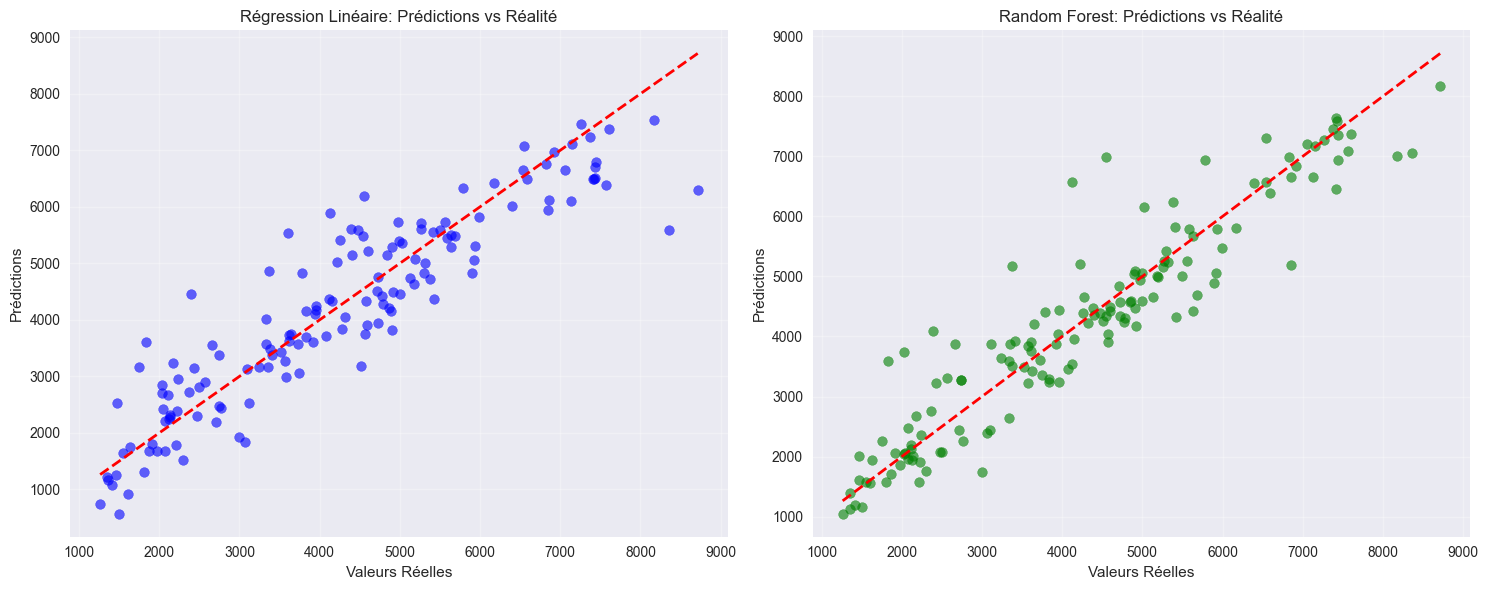

In [8]:
# Graphiques Prédictions vs Réalité
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Prédictions vs Réalité - Régression Linéaire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs Réelles')
axes[0].set_ylabel('Prédictions')
axes[0].set_title('Régression Linéaire: Prédictions vs Réalité')
axes[0].grid(True, alpha=0.3)

# 2. Prédictions vs Réalité - Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.6, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valeurs Réelles')
axes[1].set_ylabel('Prédictions')
axes[1].set_title('Random Forest: Prédictions vs Réalité')
axes[1].grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()
